In [43]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
# === USTAWIENIA PARAMETRÓW MODELU ===

IMG_SIZE = 224     # rozmiar obrazu (224x224 -standard ImageNet)
input_shape = (IMG_SIZE, IMG_SIZE, 3)  # 3 kaanały = RGB - MobileNetV2 -nie obsługuje grayscale
num_classes = 3   # ile klas klasyfikujemy - podany by model wiedział ile neuronów w warstwie wyjściowej ma utworzyć
learning_rate = 1e-4   # współczynnik uczenia (dla optymalizatora Adam) dość małe by zapenić stabilne uczenie


In [ ]:
# === FUNKCJE POMOCNICZE: TRENING | ZAPIS | WIZUALIZACJA ===

def plot_history(history, out_dir="plots", prefix="model"):     # Tworzy i zapisuje wykresy dokładności i straty (loss) na zbiorze treningowym i walidacyjnym
    os.makedirs(out_dir, exist_ok=True)
    plt.figure()
    plt.plot(history.history["accuracy"], label="train_acc")
    plt.plot(history.history["val_accuracy"], label="val_acc")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{out_dir}/{prefix}_accuracy.png")
    plt.close()

    plt.figure()
    plt.plot(history.history["loss"], label="train_loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{out_dir}/{prefix}_loss.png")
    plt.close()

def plot_conf_matrix(model, generator, out_dir="plots", prefix="model"):    # Tworzy macierz pomyłek (confusion matrix) i zapisuje ją jako obraz oraz zapisuje raport klasyfikacji do pliku tekstowego.
    os.makedirs(out_dir, exist_ok=True)
    y_true, y_pred = [], []
    class_names = list(generator.class_indices.keys())
    generator.reset()
    for _ in range(len(generator)):
        x_batch, y_batch = next(generator)
        preds = model.predict(x_batch, verbose=0)
        y_true.extend(np.argmax(y_batch, axis=1))   #prawdziwe etykiety
        y_pred.extend(np.argmax(preds, axis=1))     # przewidziane etykiety

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.savefig(f"{out_dir}/{prefix}_confusion.png")
    plt.close()

    report = classification_report(y_true, y_pred, target_names=class_names)
    with open(f"{out_dir}/{prefix}_classification_report.txt", "w") as f:
        f.write(report)

def save_history(history, filename):    # zapisuje dane w json
    with open(filename, "w") as f:
        json.dump(history.history, f)

def train_model(model, model_name, train_gen, val_gen, epochs=30):
    print(f"\n== Training {model_name} ==\n")
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True), # Przerwanie trenowanie, jeśli val_loss się nie poprawia przez 3 epoki
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2),  # Jeśli val_loss się nie poprawia przez 2 epoki, zmniejsza learning rate o połowę
        ModelCheckpoint(f"models/{model_name}.keras", save_best_only=True)  # Zapisuje najlepszy model do pliku
    ]

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=callbacks
    )

    plot_history(history, out_dir="plots", prefix=model_name)
    plot_conf_matrix(model, val_gen, out_dir="plots", prefix=model_name)
    save_history(history, f"plots/{model_name}_history.json")
    model.save(f"models/{model_name}_final.keras")
    return history

def plot_comparison(histories, metric="accuracy", out_file="comparison.png"):
    plt.figure(figsize=(7, 5))
    for name, hist in histories.items():
        plt.plot(hist[metric], label=f"{name} train")
        plt.plot(hist["val_" + metric], label=f"{name} val", linestyle="--")
    plt.title(f"Comparison: {metric}")
    plt.xlabel("Epoch")
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"plots/{out_file}")
    plt.close()

In [ ]:
# === KATALOGI NA MODELE I WYKRESY ===
os.makedirs("models", exist_ok=True)
os.makedirs("plots", exist_ok=True)

In [ ]:
# === WCZYTANIE DNAYCH I AUGMENTACJA ===
train_datagen = ImageDataGenerator(     
    rescale=1./255,             # Przeskalowuje piksele z zakresu [0, 255] → [0, 1] (normalizacja)
    rotation_range=25,          # Losowo obraca obraz w zakresie ±25°
    width_shift_range=0.2,      # Przesuwa obraz poziomo o maksymalnie 20% szerokości
    height_shift_range=0.2,     # Przesuwa obraz pionowo o maks. 20% wysokości
    zoom_range=0.2,             # Zoomuje w obraz losowo o ±20%
    horizontal_flip=True,       # Odbija obraz poziomo (np. lustrzanie)
    fill_mode='nearest'         # Wypełnia nowe piksele po transformacji najbliższymi wartościami
)
val_datagen = ImageDataGenerator(rescale=1./255)    # Walidacja jest jedynie normalizowana

train_generator = train_datagen.flow_from_directory(    # Wczytuje obrazy treningowe z katalogu
    'dataset/train',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='categorical'
)
val_generator = val_datagen.flow_from_directory(    # Wczytuje obrazy walidacyjne  z katalogu
    'dataset/valid',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='categorical'
)

Found 8393 images belonging to 3 classes.
Found 2277 images belonging to 3 classes.


In [49]:
# === MODEL CNN ===
cnn_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D(),
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Flatten(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

cnn_model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

cnn_history = train_model(cnn_model, "CNN", train_generator, val_generator)


== Training CNN ==

Epoch 1/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 623s 2s/step - accuracy: 0.7865 - loss: 1.2147 - val_accuracy: 0.3474 - val_loss: 15.5414 - learning_rate: 1.0000e-04
Epoch 2/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 604s 2s/step - accuracy: 0.8822 - loss: 0.2872 - val_accuracy: 0.8849 - val_loss: 0.4410 - learning_rate: 1.0000e-04
Epoch 3/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 602s 2s/step - accuracy: 0.9022 - loss: 0.2542 - val_accuracy: 0.9223 - val_loss: 0.2108 - learning_rate: 1.0000e-04
Epoch 4/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 630s 2s/step - accuracy: 0.9135 - loss: 0.2155 - val_accuracy: 0.9113 - val_loss: 0.3042 - learning_rate: 1.0000e-04
Epoch 5/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 649s 2s/step - accuracy: 0.9011 - loss: 0.2483 - val_accuracy: 0.9209 - val_loss: 0.2326 - learning_rate: 1.0000e-04
Epoch 6/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 652s 2s/step - accuracy: 0.9254 - loss: 0.1816 - val_accuracy: 0.8520 - val_loss: 0.7244 - learning_rate: 5.0000e-05


In [50]:
# === MODEL MOBILENETV2 ===
mobilenet_base = tf.keras.applications.MobileNetV2(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet'
)
mobilenet_base.trainable = False

mobilenet_model = Sequential([
    mobilenet_base,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

mobilenet_model.compile(optimizer=Adam(learning_rate=learning_rate),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

mobilenet_history = train_model(mobilenet_model, "MobileNetV2", train_generator, val_generator)



== Training MobileNetV2 ==

Epoch 1/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 338s 1s/step - accuracy: 0.4225 - loss: 1.2218 - val_accuracy: 0.7391 - val_loss: 0.6888 - learning_rate: 1.0000e-04
Epoch 2/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 340s 1s/step - accuracy: 0.7259 - loss: 0.6643 - val_accuracy: 0.8476 - val_loss: 0.4879 - learning_rate: 1.0000e-04
Epoch 3/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 335s 1s/step - accuracy: 0.8183 - loss: 0.4980 - val_accuracy: 0.8722 - val_loss: 0.4088 - learning_rate: 1.0000e-04
Epoch 4/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 333s 1s/step - accuracy: 0.8444 - loss: 0.4295 - val_accuracy: 0.8849 - val_loss: 0.3615 - learning_rate: 1.0000e-04
Epoch 5/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 333s 1s/step - accuracy: 0.8636 - loss: 0.3829 - val_accuracy: 0.8924 - val_loss: 0.3243 - learning_rate: 1.0000e-04
Epoch 6/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 335s 1s/step - accuracy: 0.8741 - loss: 0.3440 - val_accuracy: 0.9038 - val_loss: 0.2965 - learning_rate: 1.0000e-04
Epoch 7/30
263/263 ━━━━━━━━━━

In [52]:
# === PORÓWNANIE ===
with open("plots/CNN_history.json") as f1, open("plots/MobileNetV2_history.json") as f2:
    cnn_hist = json.load(f1)
    mobilenet_hist = json.load(f2)

plot_comparison({"CNN": cnn_hist, "MobileNetV2": mobilenet_hist}, metric="accuracy", out_file="comparison_accuracy.png")
plot_comparison({"CNN": cnn_hist, "MobileNetV2": mobilenet_hist}, metric="loss", out_file="comparison_loss.png")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


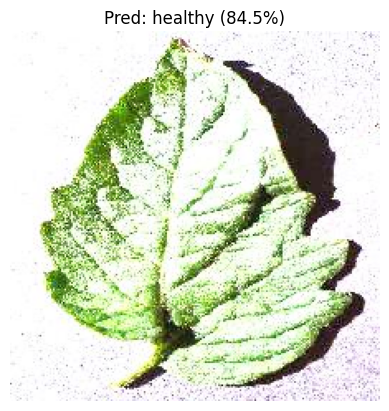

Obrazek: dataset/test\healthy\0ed55b5a-55e6-4c9c-bce4-9eba61bc3a6b___RS_HL 9889_newPixel25.JPG
Predykcja: healthy (84.53%)
 - Bacterial_spot: 12.83%
 - Leaf_Mold: 2.64%
 - healthy: 84.53%


In [67]:
import random
# === PREDYKCJA LOSOWEGO ZDJĘCIA Z TEST SETU ===
def predict_random_image(test_dir, model_path, class_indices):
    all_classes = os.listdir(test_dir)
    chosen_class = random.choice(all_classes)
    class_path = os.path.join(test_dir, chosen_class)
    image_file = random.choice(os.listdir(class_path))
    image_path = os.path.join(class_path, image_file)

    img = image.load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    model = tf.keras.models.load_model(model_path)
    class_names = [cls for cls, idx in sorted(class_indices.items(), key=lambda x: x[1])]

    prediction = model.predict(img_array)[0]
    predicted_index = np.argmax(prediction)
    predicted_class = class_names[predicted_index]
    confidence = prediction[predicted_index]

    plt.imshow(img)
    plt.title(f"Pred: {predicted_class} ({confidence*100:.1f}%)")
    plt.axis('off')
    plt.show()

    print(f"Obrazek: {image_path}")
    print(f"Predykcja: {predicted_class} ({confidence*100:.2f}%)")
    for i, prob in enumerate(prediction):
        print(f" - {class_names[i]}: {prob*100:.2f}%")

# Przykład użycia
predict_random_image("dataset/test", "models/MobileNetV2_final.keras", train_generator.class_indices)